In [5]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob
from IPython import display

sys.path.append('../../benchmarks_unknown/')
from benchmark_functions import DejongConstr, AckleyPathConstr, BraninConstr, HyperEllipsoidConstr, LevyConstr
from benchmark_functions import MichalewiczConstr, RastriginConstr, SchwefelConstr, StyblinskiTangConstr
from benchmark_functions import DiscreteAckleyConstr, DiscreteDoubleWellConstr, DiscreteMichalewiczConstr
from benchmark_functions import LinearFunnelConstr, NarrowFunnelConstr

sns.set(style='ticks', context='notebook', font_scale=1.2)

In [45]:
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])
plt.register_cmap(cmap=_cmap)
plt.register_cmap(cmap=_cmap_r)

# -----------------------------------
# ColorMap where white is transparent
# -----------------------------------

# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(1.0,0.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='gray_alpha',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)


def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='golem'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_surface(surface, ax=None, N=100, constraints=None, plot_min=True, contour_lines=True):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=contour_lines, contour_labels=False, 
                 labels_fs=12, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap='golem')
    
    if plot_min is True:
        for param in surface.minima:
            x_min = param['params']
            ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)
    
    if constraints is not None:
        params = [{'x0':x[0], 'x1':x[1]} for x in X]
        y_feas =  [constraints(p) for p in params]
        Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
        ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray_alpha', alpha=0.5, interpolation='nearest')
        
class ObjEvaluator:
    def __init__(self, surface):
        self.surface = surface
    def __call__(self, x):
        return np.squeeze(self.surface.run(x))[()]

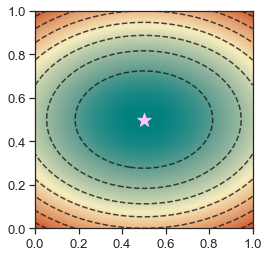

In [7]:
from olympus.surfaces import Surface
from gryffin import Gryffin
from gryffin.random_sampler import RandomSampler
from gryffin.acquisition.gradient_optimizer import GradientOptimizer
from gryffin.acquisition.genetic_optimizer import GeneticOptimizer


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

surface1 = Surface(kind='HyperEllipsoid', param_dim=2)

plot_surface(surface1, ax=ax, N=100)

In [26]:
config = {
        "general": {
             "batches": 1,
             "num_cpus": 1,
             "boosted":  False,
             "caching": False,
             "save_database": False,
             "sampling_strategies": 1,
             "random_seed": 42,
             "acquisition_optimizer": 'adam'
                },
        "parameters": [{"name": "x0", "type": "continuous", "low": 0., "high": 1.},
                       {"name": "x1", "type": "continuous", "low": 0., "high": 1.}],
        "objectives": [{"name": "obj", "goal": "min"}]
    }

gryffin = Gryffin(config_dict=config)

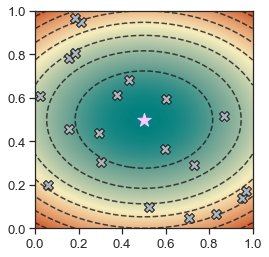

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

surface1 = Surface(kind='HyperEllipsoid', param_dim=2)
evaluator = ObjEvaluator(surface1)

plot_surface(surface1, ax=ax, N=100)

np.random.seed(42)
X = gryffin.random_sampler.draw(num=20)
ax.scatter(X.T[0], X.T[1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

In [11]:
data_dict = {}

def plot_opt_progress(X_updated, ax=None, fig=None, savefigs=False, namefigs=''):
    
    if ax is None:
        fig, ax = plt.subplots()
        
    c = 0.
    for i, Xi in enumerate(X_updated):
        display.clear_output(wait=True)
        if c > 1.:
            c = 1.
        
        for Xi0, Xi1 in zip(Xi.T[0], Xi.T[1]):
            if Xi0 > 1e-6 and Xi1 > 1e-6:
                ax.scatter(Xi0, Xi1, marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
        
        if savefigs is True:
            fig.savefig(f'gif_{namefigs}_{i:02}.png', dpi=300, bbox_inches='tight')
        
        c += 1. / max_iter

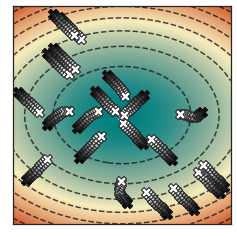

In [47]:
#optimizer = GradientOptimizer(config=gryffin.config)
#optimizer.set_func(evaluator, ignores=[False, False])

from gryffin.acquisition.gradient_optimizer import AdamOptimizer

optimizer = AdamOptimizer(eta=0.01, decay=False)
optimizer.set_func(evaluator, select=[True, True])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

surface1 = Surface(kind='HyperEllipsoid', param_dim=2)
plot_surface(surface1, ax=ax, N=100)

np.random.seed(42)
num = 20
X = gryffin.random_sampler.draw(num=num)

c = 0.
ax.scatter(X.T[0], X.T[1], marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
ax.set_xticks([])
ax.set_yticks([])

#fig.savefig(f'gif_adam_00.png', dpi=300, bbox_inches='tight')

# get updates
max_iter = 10
X_updated = np.empty(shape=(max_iter + 1, num, 2))
X_updated[0, : , :] = X

for i, Xi in enumerate(X):
    optimizer.reset()  # reset for each sample
    for j in range(max_iter):
        Xi = optimizer.get_update(Xi)
        X_updated[j+1, i, 0] = Xi[0]
        X_updated[j+1, i, 1] = Xi[1]
        
        
plot_opt_progress(X_updated, ax=ax, savefigs=True, namefigs='adam', fig=fig)

#for i, Xi in enumerate(X_updated):
#    display.clear_output(wait=True)
#    c += 1. / max_iter
#    if c > 1.:
#        c = 1.
#    ax.scatter(Xi.T[0], Xi.T[1], marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
    #fig.savefig(f'gif_adam_{i+1:02}.png', dpi=300, bbox_inches='tight')
    
data_dict['adam'] = X_updated

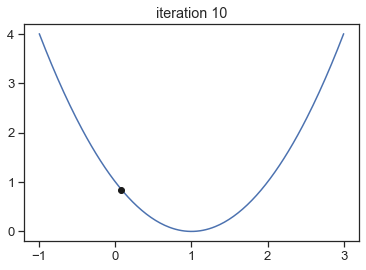

In [7]:
## test adam
from IPython.display import clear_output
from gryffin.acquisition.gradient_optimizer import AdamOptimizer

import matplotlib.pyplot as plt
import seaborn as sns

adam = AdamOptimizer(eta=0.1)

def func(x):
    return (x - 1)**2

adam.set_func(func, select=[True])

domain = np.linspace(-1, 3, 200)
values = func(domain)

start = np.zeros(1) - 0.8

for i in range(10):
    clear_output(wait=True)

    plt.clf()
    plt.plot(domain, values)
    plt.plot(start, func(start), marker='o', color='k')
    plt.title(f'iteration {i+1}')

    start = adam.get_update(start)

    plt.pause(0.05)

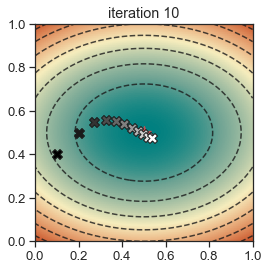

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

surface1 = Surface(kind='HyperEllipsoid', param_dim=2)
evaluator = ObjEvaluator(surface1)

plot_surface(surface1, ax=ax, N=100)


adam = AdamOptimizer(eta=0.1, decay=True)
adam.set_func(evaluator, select=[True, True])


sample = np.array([0.1, 0.4])
c = 0.
ax.scatter(sample[0], sample[1], marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
ax.set_title(f'iteration 0')


# get updates
max_iter = 10
X_updated = np.empty(shape=(max_iter, 2))
for i in range(max_iter):
    sample = adam.get_update(sample)
    X_updated[i, 0] = sample[0]
    X_updated[i, 1] = sample[1]

for i, Xi in enumerate(X_updated):
    display.clear_output(wait=True)
    c += 1. / max_iter
    if c > 1.:
        c = 1.
    ax.scatter(Xi.T[0], Xi.T[1], marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
    ax.set_title(f'iteration {i+1}')

In [21]:
feature_types = ['continuous', 'continuous', 'categorical']

In [26]:
b1 = np.array([True if f == 'continuous' else False for f in feature_types])
b2 = np.array([True if f == 'categorical' else False for f in feature_types])

## Genetic

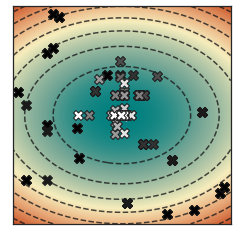

In [49]:
optimizer = GeneticOptimizer(config=gryffin.config)
optimizer.set_func(evaluator, ignores=[False, False])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

surface1 = Surface(kind='HyperEllipsoid', param_dim=2)
plot_surface(surface1, ax=ax, N=100)

np.random.seed(42)
X = gryffin.random_sampler.draw(num=20)

c = 0
ax.scatter(X.T[0], X.T[1], marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
ax.set_xticks([])
ax.set_yticks([])
#fig.savefig(f'gif_genetic_00.png', dpi=300, bbox_inches='tight')

#X_updated = X.copy()
max_iter = 10
X_updated = np.empty(shape=(max_iter + 1, num, 2))
X_updated[0, : , :] = X
X_before = X

for i in range(1, max_iter+1, 1):
    X_next = optimizer.optimize(samples=X_before, max_iter=1)
    X_updated[i, : , :] = X_next
    X_before = X_next
    
    #c += 1. / max_iter
    #if c > 1.:
    #    c = 1.
    #ax.scatter(X_updated.T[0], X_updated.T[1], marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
    #ax.scatter(X_next.T[0], X_next.T[1], marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
    #fig.savefig(f'gif_genetic_{i:02}.png', dpi=300, bbox_inches='tight')
    
    
plot_opt_progress(X_updated, ax=ax, savefigs=True, namefigs='genetic', fig=fig)    

data_dict['genetic'] = X_updated

# Constrained examples

In [12]:
config = {
        "general": {
             "batches": 1,
             "num_cpus": 1,
             "boosted":  False,
             "caching": False,
             "save_database": False,
             "sampling_strategies": 1,
             "random_seed": 42,
             "acquisition_optimizer": 'adam'
                },
        "parameters": [{"name": "x0", "type": "continuous", "low": 0., "high": 1.},
                       {"name": "x1", "type": "continuous", "low": 0., "high": 1.}],
        "objectives": [{"name": "obj", "goal": "min"}]
    }

def known_constraints(param):
    x0 = param['x0']
    x1 = param['x1']
    if (x0-0.5)**2 + (x1-0.5)**2 < 0.03:
        return False
    return True
    
gryffin = Gryffin(config_dict=config, known_constraints=known_constraints)

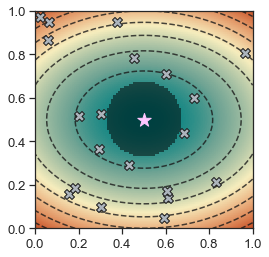

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

surface1 = Surface(kind='HyperEllipsoid', param_dim=2)
evaluator = ObjEvaluator(surface1)

plot_surface(surface1, ax=ax, N=100, constraints=known_constraints)

np.random.seed(42)
X = gryffin.random_sampler.draw(num=20)
ax.scatter(X.T[0], X.T[1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

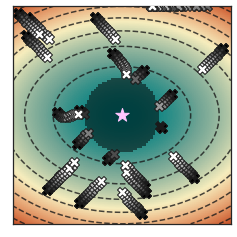

In [14]:
from gryffin.acquisition.gradient_optimizer import GradientOptimizer

optimizer = GradientOptimizer(config=gryffin.config, constraints=[known_constraints])
optimizer.set_func(evaluator)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

surface1 = Surface(kind='HyperEllipsoid', param_dim=2)
plot_surface(surface1, ax=ax, N=100, constraints=known_constraints)

np.random.seed(42)
num = 20
X = gryffin.random_sampler.draw(num=num)

c = 0.
ax.scatter(X.T[0], X.T[1], marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
ax.set_xticks([])
ax.set_yticks([])

#fig.savefig(f'gif_adam_00.png', dpi=300, bbox_inches='tight')

# get updates
max_iter = 10
X_updated = np.empty(shape=(max_iter + 1, num, 2))
X_updated[0, : , :] = X


for i, Xi in enumerate(X):
    optimizer.opt_con.reset()
    for j in range(max_iter):
        Xi_opt = optimizer.opt_con.get_update(Xi)
        param = {'x0':Xi_opt[0], 'x1':Xi_opt[1]}
        if known_constraints(param) is False:
            break
        X_updated[j+1, i, 0] = Xi_opt[0]
        X_updated[j+1, i, 1] = Xi_opt[1]
        Xi = Xi_opt
        
        
plot_opt_progress(X_updated, ax=ax, savefigs=True, namefigs='adam_constr', fig=fig)

#for i, Xi in enumerate(X_updated):
#    display.clear_output(wait=True)
#    c += 1. / max_iter
#    if c > 1.:
#        c = 1.
    # exclude empty entries
#    for Xi0, Xi1 in zip(Xi.T[0], Xi.T[1]):
#        if Xi0 > 1e-6 and Xi1 > 1e-6:
#            ax.scatter(Xi0, Xi1, marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
    #fig.savefig(f'gif_adam_{i+1:02}.png', dpi=300, bbox_inches='tight')
    
data_dict['adam_constr'] = X_updated

### Genetic

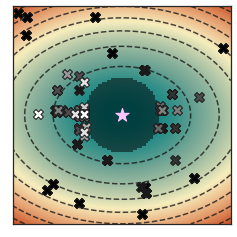

In [15]:
optimizer = GeneticOptimizer(config=gryffin.config, constraints=[known_constraints])
optimizer.set_func(evaluator, ignores=[False, False])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

surface1 = Surface(kind='HyperEllipsoid', param_dim=2)
plot_surface(surface1, ax=ax, N=100, constraints=known_constraints)

np.random.seed(42)
X = gryffin.random_sampler.draw(num=20)

c = 0
ax.scatter(X.T[0], X.T[1], marker='X', s=100, color=f'{c}', edgecolor='k', zorder=20)
ax.set_xticks([])
ax.set_yticks([])
#fig.savefig(f'gif_genetic_00.png', dpi=300, bbox_inches='tight')


max_iter = 10
X_updated = np.empty(shape=(max_iter + 1, num, 2))
X_updated[0, : , :] = X
X_before = X

for i in range(1, max_iter+1, 1):
    X_next = optimizer.optimize(samples=X_before, max_iter=1)
    X_updated[i, : , :] = X_next
    X_before = X_next
    
#plot_opt_progress(X_updated, ax=ax, savefigs=True, namefigs='genetic_constr', fig=fig)
plot_opt_progress(X_updated, ax=ax, savefigs=False, namefigs='genetic_constr', fig=fig)
    
data_dict['genetic_constr'] = X_updated

#### Plot example of constrained GA updates

In [69]:
def dict_to_array(d):
    return np.array([d['x0'], d['x1']])

def array_to_dict(a):
    return {'x0':a[0], 'x1':a[1]}

def genetic_feasibility_constraint(child, parent, known_constraints):
    
    feasible = known_constraints(child)
    child_array = dict_to_array(child)
    parent_array = dict_to_array(parent)
    
    history = []
    history.append({'child':child_array, 'parent':parent_array})
    
    counter = 0
    while feasible is False:
        midpoint = np.mean(np.array([parent_array, child_array]), axis=0)
        midpoint_feas = known_constraints(array_to_dict(midpoint))
        
        if midpoint_feas is True:
            # shift parent
            parent_array = midpoint
        else:
            # shift child
            child_array = midpoint
            
        history.append({'child':child_array, 'parent':parent_array})
        
        if np.linalg.norm(parent_array-child_array) < 0.001:
            break
            
        # just to catch infinite loops
        counter += 1
        if counter > 100:
            break
    
    return history
            
history = genetic_feasibility_constraint({'x0':0.5, 'x1':0.5}, {'x0':0.1, 'x1':0.1}, known_constraints)
print(len(history))

11


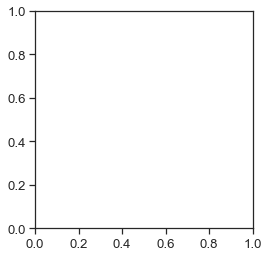

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

surface1 = Surface(kind='HyperEllipsoid', param_dim=2)

for i, d in enumerate(history):
    display.clear_output(wait=True)
    
    plot_surface(surface1, ax=ax, N=100, constraints=known_constraints, plot_min=False, contour_lines=True)
    
    ax.scatter(d['child'][0], d['child'][1], marker='X', s=160, color='white', edgecolor='k', zorder=20, label='Child')
    ax.scatter(d['parent'][0], d['parent'][1], marker='X', s=160, color='gray', edgecolor='k', zorder=20, label='Parent')
    ax.plot([d['child'][0], d['parent'][0]], [d['child'][1], d['parent'][1]], linestyle='-', color='#ffc6ff', linewidth=3)
    
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    _ = ax.legend(frameon=True)
    
    fig.savefig(f'gif_gene_constr_hist_{i:02}.png', dpi=300, bbox_inches='tight')
    ax.cla()

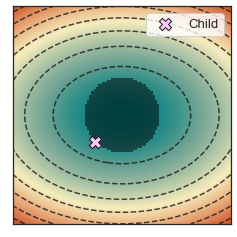

In [74]:
from time import sleep

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

surface1 = Surface(kind='HyperEllipsoid', param_dim=2)

d = history[-1]
    
plot_surface(surface1, ax=ax, N=100, constraints=known_constraints, plot_min=False, contour_lines=True)

ax.scatter(d['parent'][0], d['parent'][1], marker='X', s=150, color='#ffc6ff', edgecolor='k', zorder=20, label='Child')
    
_ = ax.set_xticks([])
_ = ax.set_yticks([])

_ = ax.legend(frameon=True)

i = len(history)
fig.savefig(f'gif_gene_constr_hist_{i:02}.png', dpi=300, bbox_inches='tight')

Average complexity if $O(log N)$ where $N = |x_{parent}-x_{child}|_2 / c$ where $c$ is the convergence criterion

### Plot All

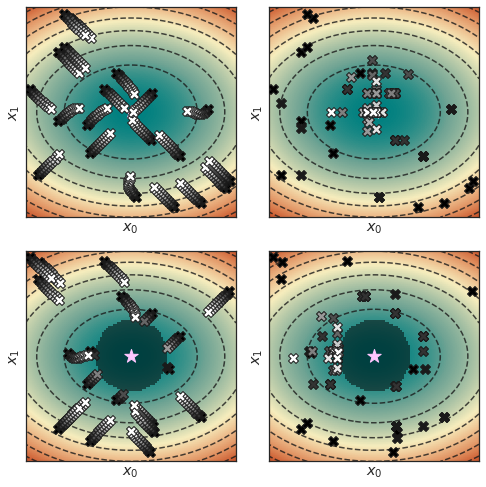

In [66]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7), sharex=True, sharey=True)

surface = Surface(kind='HyperEllipsoid', param_dim=2)

ax = axes[0,0]
plot_surface(surface, ax=ax, N=100, constraints=None)
plot_opt_progress(data_dict['adam'], ax=ax, savefigs=False)

ax = axes[0,1]
plot_surface(surface, ax=ax, N=100, constraints=None)
plot_opt_progress(data_dict['genetic'], ax=ax, savefigs=False)

ax = axes[1,0]
plot_surface(surface, ax=ax, N=100, constraints=known_constraints)
plot_opt_progress(data_dict['adam_constr'], ax=ax, savefigs=False)

ax = axes[1,1]
plot_surface(surface, ax=ax, N=100, constraints=known_constraints)
plot_opt_progress(data_dict['genetic_constr'], ax=ax, savefigs=False)

# labels
_ = axes[0,0].set_xticks([])
_ = axes[0,0].set_yticks([])

for i in range(2):
    for j in range(2):
        _ = axes[i,j].set_xlabel('$x_0$')
        _ = axes[i,j].set_ylabel('$x_1$')
        
#axes[0,0].set_title('Adam')
#axes[0,1].set_title('Genetic')
        
plt.tight_layout()
fig.savefig('toy_opt_examples.pdf')